# <center>Class 12: Time Series Regressions</center>

In [2]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels as sm
import statsmodels.api as smapi

from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [6]:
# !pip install arch

   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   - -------------------------------------- 30.7/926.2 kB 1.3 MB/s eta 0:00:01
   -------------- ------------------------- 327.7/926.2 kB 4.1 MB/s eta 0:00:01
   ------------------------------------ --- 839.7/926.2 kB 6.6 MB/s eta 0:00:01
   ---------------------------------------- 926.2/926.2 kB 5.9 MB/s eta 0:00:00


In [7]:
from arch.unitroot import PhillipsPerron, ADF

## Data - Equity Returns

In [10]:
path = os.path.join(os.pardir, 'data', 'stock-prices-daily.csv') # this will produce a path with the right syntax for your operating system
path

'..\\data\\stock-prices-daily.csv'

In [12]:
df_stocks = pd.read_csv(path)

In [14]:
df_stocks

,ym,year,month,date,p_SP500,p_MSFT
0,1997-12,1997,12,1997-12-31,970.429993,16.156250
1,1998-01,1998,1,1998-01-02,975.039978,16.390625
2,1998-01,1998,1,1998-01-05,977.070007,16.296875
3,1998-01,1998,1,1998-01-06,966.580017,16.390625
4,1998-01,1998,1,1998-01-07,964.000000,16.195313
...,...,...,...,...,...,...
5279,2018-12,2018,12,2018-12-24,2351.100098,94.129997
5280,2018-12,2018,12,2018-12-26,2467.699951,100.559998
5281,2018-12,2018,12,2018-12-27,2488.830078,101.180000
5282,2018-12,2018,12,2018-12-28,2485.739990,100.389999


In [16]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5284 entries, 0 to 5283
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ym       5284 non-null   object 
 1   year     5284 non-null   int64  
 2   month    5284 non-null   int64  
 3   date     5284 non-null   object 
 4   p_SP500  5284 non-null   float64
 5   p_MSFT   5284 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 247.8+ KB


In [18]:
df_stocks.date = pd.to_datetime(df_stocks.date, format= '%Y-%m-%d')

In [20]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5284 entries, 0 to 5283
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ym       5284 non-null   object        
 1   year     5284 non-null   int64         
 2   month    5284 non-null   int64         
 3   date     5284 non-null   datetime64[ns]
 4   p_SP500  5284 non-null   float64       
 5   p_MSFT   5284 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 247.8+ KB


#### Feature engineering & EDA

In [23]:
df_stocks["lnp_MSFT"] = np.log(df_stocks["p_MSFT"])

In [25]:
df_stocks["lnp_SP500"] = np.log(df_stocks["p_SP500"])

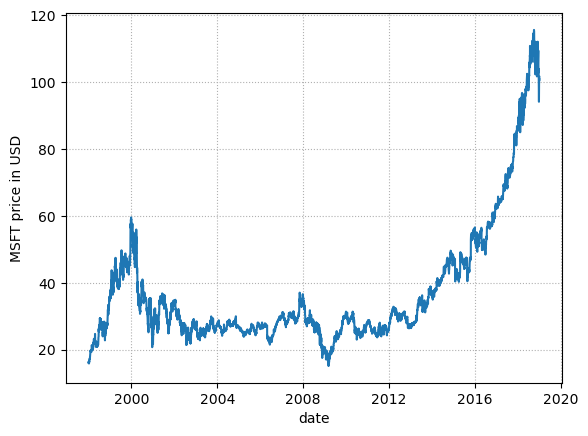

In [27]:
sns.lineplot(data = df_stocks, x = 'date', y = 'p_MSFT')
plt.ylabel('MSFT price in USD')
plt.grid(linestyle = 'dotted');

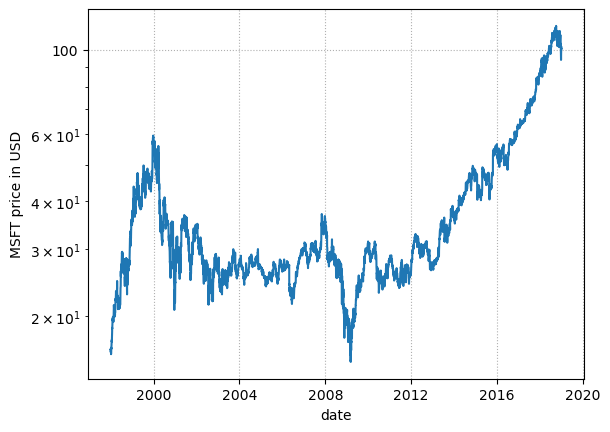

In [29]:
g = sns.lineplot(data = df_stocks, x = 'date', y = 'p_MSFT')
g.set_yscale('log')
ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
g.set_yticklabels(ylabels)
plt.ylabel('MSFT price in USD')
plt.grid(linestyle = 'dotted');

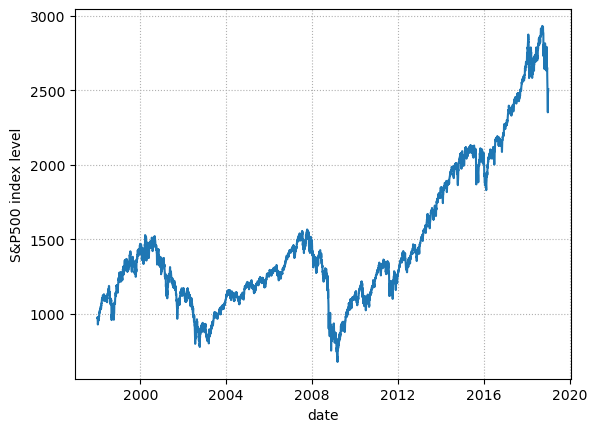

In [31]:
sns.lineplot(data = df_stocks, x = 'date', y = 'p_SP500')
plt.ylabel('S&P500 index level')
plt.grid(linestyle = 'dotted');

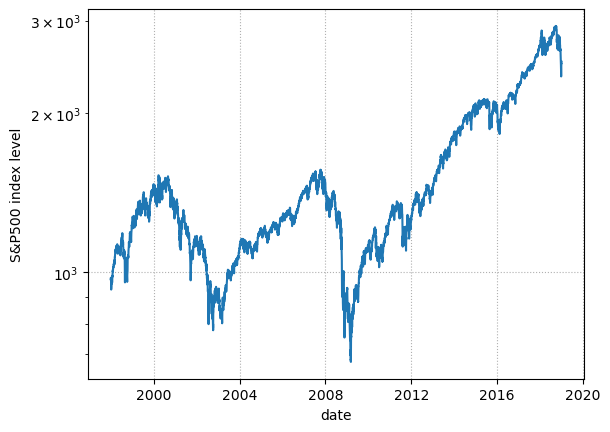

In [33]:
sns.lineplot(data = df_stocks, x = 'date', y = 'p_SP500')
plt.yscale('log')
plt.ylabel('S&P500 index level')
plt.grid(linestyle = 'dotted');

**lagged values, log differences and percentage returns - daily frequency**

In [35]:
df_stocks["l_p_MSFT"] = df_stocks["p_MSFT"].shift()
df_stocks["l_p_SP500"] = df_stocks["p_SP500"].shift()
df_stocks["d_p_MSFT"] = df_stocks["p_MSFT"] - df_stocks["l_p_MSFT"]
df_stocks["d_p_SP500"] = df_stocks["p_SP500"] - df_stocks["l_p_SP500"]
df_stocks["PctRetMSFT"] = df_stocks["d_p_MSFT"] / df_stocks["l_p_MSFT"] * 100
df_stocks["PctRetSP500"] = df_stocks["d_p_SP500"] / df_stocks["l_p_SP500"] * 100

df_stocks["d_lnp_MSFT"] = np.log(df_stocks["p_MSFT"]) - np.log(df_stocks["p_MSFT"].shift())
df_stocks["d_lnp_SP500"] = np.log(df_stocks["p_SP500"]) - np.log(df_stocks["p_SP500"].shift())

In [37]:
df_stocks.dropna(inplace= True)

**lagged values, log differences and percentage returns - monthly frequency**

In [40]:
df_stocks[["date", "year", "month", "p_SP500", "p_MSFT"]].groupby(df_stocks["date"].dt.to_period("M")).last()

,date,year,month,p_SP500,p_MSFT
date,,,,,
1998-01,1998-01-30,1998,1,980.280029,18.648438
1998-02,1998-02-27,1998,2,1049.339966,21.187500
1998-03,1998-03-31,1998,3,1101.750000,22.375000
1998-04,1998-04-30,1998,4,1111.750000,22.531250
1998-05,1998-05-29,1998,5,1090.819946,21.203125
...,...,...,...,...,...
2018-08,2018-08-31,2018,8,2901.520020,112.330002
2018-09,2018-09-28,2018,9,2913.979980,114.370003
2018-10,2018-10-31,2018,10,2711.739990,106.809998


In [42]:
df_stocks_monthly = (
    df_stocks[["date", "year", "month", "p_SP500", "p_MSFT"]]
    .groupby(df_stocks["date"].dt.to_period("M"))
    .last()
    .reset_index(drop=True)
)

In [44]:
df_stocks_monthly

,date,year,month,p_SP500,p_MSFT
0,1998-01-30,1998,1,980.280029,18.648438
1,1998-02-27,1998,2,1049.339966,21.187500
2,1998-03-31,1998,3,1101.750000,22.375000
3,1998-04-30,1998,4,1111.750000,22.531250
4,1998-05-29,1998,5,1090.819946,21.203125
...,...,...,...,...,...
247,2018-08-31,2018,8,2901.520020,112.330002
248,2018-09-28,2018,9,2913.979980,114.370003
249,2018-10-31,2018,10,2711.739990,106.809998
250,2018-11-30,2018,11,2760.169922,110.889999


In [46]:
df_stocks_monthly["l_p_MSFT"] = df_stocks_monthly["p_MSFT"].shift()
df_stocks_monthly["l_p_SP500"] = df_stocks_monthly["p_SP500"].shift()
df_stocks_monthly["d_p_MSFT"] = df_stocks_monthly["p_MSFT"] - df_stocks_monthly["l_p_MSFT"]
df_stocks_monthly["d_p_SP500"] = df_stocks_monthly["p_SP500"] - df_stocks_monthly["l_p_SP500"]
df_stocks_monthly["PctRetMSFT"] = df_stocks_monthly["d_p_MSFT"] / df_stocks_monthly["l_p_MSFT"] * 100
df_stocks_monthly["PctRetSP500"] = (
    df_stocks_monthly["d_p_SP500"] / df_stocks_monthly["l_p_SP500"] * 100
)

df_stocks_monthly["d_lnp_MSFT"] = np.log(df_stocks_monthly["p_MSFT"]) - np.log(df_stocks_monthly["p_MSFT"].shift())
df_stocks_monthly["d_lnp_SP500"] = np.log(df_stocks_monthly["p_SP500"]) - np.log(df_stocks_monthly["p_SP500"].shift())

In [48]:
df_stocks_monthly.dropna(inplace = True)

## Testing for Stationarity/Unit Root

#### Daily data

We cover two types of stationarity test:
- Augmented Dickey-Fuller (ADF)
- Phillips-Perron

In each case we test for:
- 'n': no constant term and no linear time trend
- 'c': constant term only
- 'ct': constant term and linear time trend

In all cases $H_0$: there is *unit root*, that is the *time series in NOT stationary*. $H_1$: it is stationary.

**ADF on the levels**

In [53]:
print(ADF(df_stocks["p_MSFT"], lags = 32, trend="n").summary())

   Augmented Dickey-Fuller Results   
Test Statistic                  2.495
P-value                         0.998
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**Phillips-Perron on the levels**

<center>
    $y_i$ = $y_{i-1}$ + $\epsilon_i$
</center>

In [57]:
print(PhillipsPerron(df_stocks["p_MSFT"], lags=32, test_type="rho", trend="n").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.284
P-value                         0.994
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**Note**: When using the PhillipsPerron test from the `arch` package in Python, setting `test_type='rho'` specifies that the test statistic should be based on the re-centered regression coefficient multiplied by the number of observations (nobs). This is different from the default `test_type='tau'`, which uses the t-statistic for the test.

In simpler terms, the rho test type focuses on the level of the autoregressive coefficient, while the tau test type focuses on the t-statistic of the coefficient. Both are used to test for the presence of a unit root, but they approach the calculation differently.

<center>
    $y_i$ = $\mu$ + $y_{i-1}$ + $\epsilon_i$
</center>

In [61]:
print(PhillipsPerron(df_stocks["p_MSFT"], lags=32, test_type="rho", trend="c").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.259
P-value                         0.998
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


<center>
    $y_i$ = $\mu$ + $y_{i-1}$ + $\beta$ * $t_i$ $ + \epsilon_i$
</center>

In [64]:
print(PhillipsPerron(df_stocks["p_MSFT"], lags=32, test_type="rho", trend="ct").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.088
P-value                         0.995
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%), -21.69 (5%), -18.23 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**Phillips-Perron on the log differences**

**Note**: These are *de-trended* values. 

In [67]:
print(PhillipsPerron(df_stocks["d_lnp_MSFT"], lags=32, test_type="rho", trend="n").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic              -5172.738
P-value                         0.000
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -13.24 (1%), -7.79 (5%), -5.54 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [69]:
print(PhillipsPerron(df_stocks["d_lnp_MSFT"], lags=32, test_type="rho", trend="c").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic              -5148.130
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.60 (1%), -14.08 (5%), -11.24 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [71]:
print(PhillipsPerron(df_stocks["d_lnp_MSFT"], lags=32, test_type="rho", trend="ct").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic              -5144.422
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -29.31 (1%), -21.69 (5%), -18.23 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


#### Monthly Data

**levels**

In [75]:
print(PhillipsPerron(df_stocks_monthly["p_MSFT"], lags=32, test_type="rho", trend="n").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.299
P-value                         0.994
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -12.11 (1%), -7.03 (5%), -4.96 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [77]:
print(PhillipsPerron(df_stocks_monthly["p_MSFT"], lags=32, test_type="rho", trend="c").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                  2.578
P-value                         0.999
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.16 (1%), -13.86 (5%), -11.10 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [79]:
print(PhillipsPerron(df_stocks_monthly["p_MSFT"], lags=32, test_type="rho", trend="ct").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                  0.102
P-value                         0.996
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -28.45 (1%), -21.20 (5%), -17.88 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**log differences**

In [82]:
print(PhillipsPerron(df_stocks_monthly["d_lnp_MSFT"], lags=32, test_type="rho", trend="n").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic               -287.983
P-value                         0.000
Lags                               32
-------------------------------------

Trend: No Trend
Critical Values: -12.11 (1%), -7.03 (5%), -4.96 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [84]:
print(PhillipsPerron(df_stocks_monthly["d_lnp_MSFT"], lags=32, test_type="rho", trend="c").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic               -272.226
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -20.16 (1%), -13.86 (5%), -11.10 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [86]:
print(PhillipsPerron(df_stocks_monthly["d_lnp_MSFT"], lags=32, test_type="rho", trend="ct").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic               -252.520
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -28.45 (1%), -21.20 (5%), -17.88 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Behavior of Daily and Monthly Returns

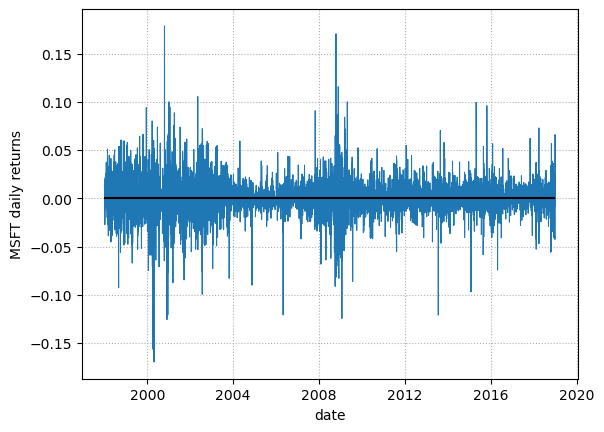

In [89]:
sns.lineplot(data = df_stocks, x = 'date', y = 'd_lnp_MSFT', size = 1, legend = None)
plt.hlines(0, df_stocks.date.min(), df_stocks.date.max(), color = 'k')
plt.grid(linestyle = 'dotted')
plt.ylabel('MSFT daily returns');

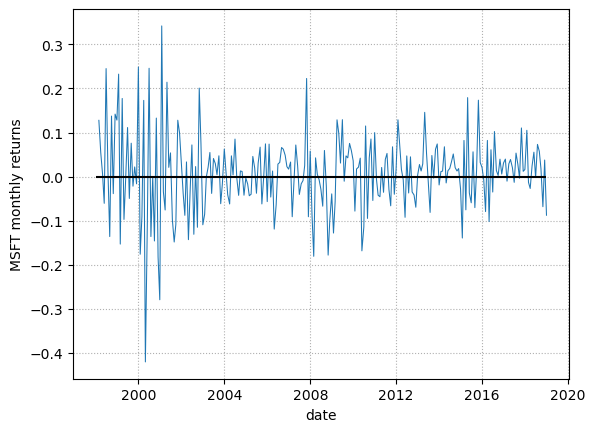

In [91]:
sns.lineplot(data = df_stocks_monthly, x = 'date', y = 'd_lnp_MSFT', size = 1, legend = None)
plt.hlines(0, df_stocks.date.min(), df_stocks.date.max(), color = 'k')
plt.grid(linestyle = 'dotted')
plt.ylabel('MSFT monthly returns');

#### Percantage return statistics

In [94]:
df_monthly_stats = df_stocks_monthly[['PctRetMSFT', 'PctRetSP500']].describe().T.round(2)
df_monthly_stats.index = ["Monthly returns on Microsoft (%)", "Monthly returns on S&P500 (%)"]
df_monthly_stats

,count,mean,std,min,25%,50%,75%,max
Monthly returns on Microsoft (%),251.0,1.08,9.05,-34.35,-4.01,1.28,5.41,40.78
Monthly returns on S&P500 (%),251.0,0.47,4.30,-16.94,-1.80,0.91,3.22,10.77


**Question**: What do we measure using the standard deviation/variance of the returns?

#### Calculating market beta

In [98]:
reg1 = smf.ols("PctRetMSFT ~ PctRetSP500", data = df_stocks_monthly).fit(cov_type="HC1")
reg2 = smf.ols("d_lnp_MSFT ~ d_lnp_SP500", data = df_stocks_monthly).fit(cov_type="HC1")
reg3 = smf.ols("PctRetMSFT ~ PctRetSP500", data = df_stocks).fit(cov_type="HC1")
reg4 = smf.ols("d_lnp_MSFT ~ d_lnp_SP500", data = df_stocks).fit(cov_type="HC1")

In [100]:
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:             PctRetMSFT   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     149.9
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           2.68e-27
Time:                        18:41:48   Log-Likelihood:                -852.47
No. Observations:                 251   AIC:                             1709.
Df Residuals:                     249   BIC:                             1716.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4861      0.452      1.077      

In [102]:
df_stocks_monthly['PtctMSFT_fitted'] = reg1.fittedvalues

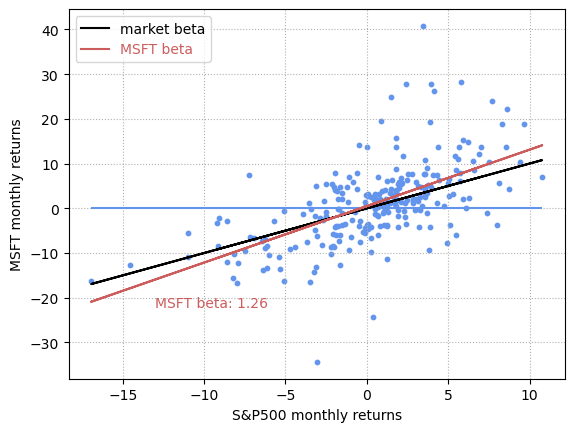

In [104]:
fig, ax = plt.subplots()

# data
ax.scatter(df_stocks_monthly.PctRetSP500, df_stocks_monthly.PctRetMSFT, s = 10, c = 'cornflowerblue')
ax.hlines(y = 0, xmin = df_stocks_monthly.PctRetSP500.min(), xmax = df_stocks_monthly.PctRetSP500.max(), color = 'cornflowerblue')
ax.plot(df_stocks_monthly.PctRetSP500, df_stocks_monthly.PctRetSP500, color = 'k', label = 'market beta')
ax.plot(df_stocks_monthly.PctRetSP500, df_stocks_monthly.PtctMSFT_fitted, 
        color = 'indianred', label = f'MSFT beta')

# aesthetics
plt.grid(linestyle = 'dotted')
plt.xlabel('S&P500 monthly returns')
plt.ylabel('MSFT monthly returns')
plt.legend(labelcolor = ['k', 'indianred'])
plt.text(x = -13, y = -22, s = f'MSFT beta: {reg1.params.PctRetSP500:.2f}', c = 'indianred');

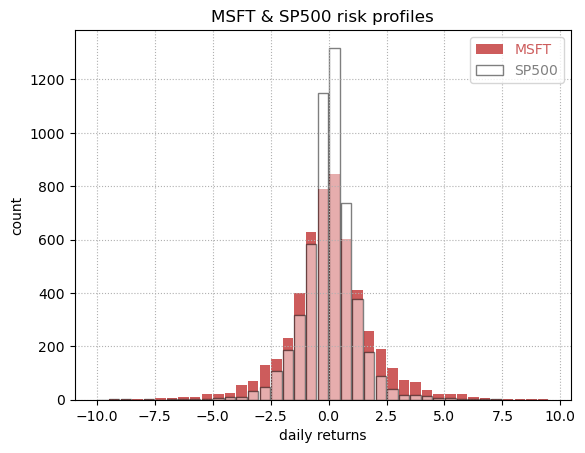

In [106]:
fig, ax = plt.subplots()
ax.hist(df_stocks.PctRetMSFT, bins = [x/2 - 10 for x in range(0,40, 1)], rwidth = 0.9, color = 'indianred', label = 'MSFT')
ax.hist(df_stocks.PctRetSP500, bins = [x/2 - 10 for x in range(0,40, 1)], rwidth = 0.9, color = 'white', edgecolor = 'k', alpha = 0.5, label = 'SP500')
plt.legend(labelcolor = ['indianred', 'grey'])
plt.xlabel('daily returns')
plt.ylabel('count')
plt.title('MSFT & SP500 risk profiles')
plt.grid(linestyle = ':');

**Question**: What does *fat tails* mean in finance?

**Market beta alternative measures**

In [110]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "PctRetSP500": "S&P500 returns",
        "d_lnp_SP500": "S&P500 returns",
    }
)
stargazer.custom_columns(
    [
        "Monthly pct change",
        "Monthly log change",
        "Daily pct change",
        "Daily log change",
    ],
    [1, 1, 1, 1],
)
stargazer

## Data - Electricity & Climate

#### electricity

In [114]:
path = os.path.join(os.pardir, 'data', 'electricity_resid_AZ.csv') # this will produce a path with the right syntax for your operating system
path

'..\\data\\electricity_resid_AZ.csv'

In [116]:
df_electricity = pd.read_csv(path)

In [118]:
df_electricity

,MY,Q
0,Jan-01,2063
1,Feb-01,1790
2,Mar-01,1690
3,Apr-01,1404
4,May-01,1984
...,...,...
202,Nov-17,1929
203,Dec-17,2198
204,Jan-18,2170
205,Feb-18,1897


In [120]:
df_electricity["date"] = pd.to_datetime(df_electricity["MY"], format="%b-%y")

df_electricity["year"] = df_electricity["date"].dt.year
df_electricity["month"] = df_electricity["date"].dt.month
df_electricity["ym"] = (df_electricity["year"].astype(str).str.cat(df_electricity["month"].astype(str), sep="m"))

df_electricity = df_electricity[["Q", "date", "ym"]]

df_electricity["lnQ"] = df_electricity["Q"].map(np.log)

In [122]:
df_electricity.head()

,Q,date,ym,lnQ
0,2063,2001-01-01,2001m1,7.631917
1,1790,2001-02-01,2001m2,7.489971
2,1690,2001-03-01,2001m3,7.432484
3,1404,2001-04-01,2001m4,7.247081
4,1984,2001-05-01,2001m5,7.592870


#### climate

In [125]:
path = os.path.join(os.pardir, 'data', 'climate_Phoenix_AZ.csv') # this will produce a path with the right syntax for your operating system
path

'..\\data\\climate_Phoenix_AZ.csv'

In [127]:
df_climate = pd.read_csv(path)

In [129]:
df_climate

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283
...,...,...,...,...,...,...,...,...
327,USW00023183,"PHOENIX AIRPORT, AZ US",2017-12,18,0,19,0,201
328,USW00023183,"PHOENIX AIRPORT, AZ US",2018-01,10,0,26,0,129
329,USW00023183,"PHOENIX AIRPORT, AZ US",2018-02,8,0,14,0,155
330,USW00023183,"PHOENIX AIRPORT, AZ US",2018-03,96,0,29,1,39


In [131]:
df_climate["tempdate"] = pd.to_datetime(df_climate["DATE"], format="%Y-%m")

df_climate["year"] = df_climate["tempdate"].dt.year
df_climate["month"] = df_climate["tempdate"].dt.month
df_climate["ym"] = (
    df_climate["year"].astype(str).str.cat(df_climate["month"].astype(str), sep="m")
)

df_climate["ndays"] = 30
df_climate.loc[df_climate["month"].isin([1, 3, 5, 7, 8, 10, 12]), "ndays"] = 31
df_climate.loc[df_climate["month"] == 2, "ndays"] = 28

for x in ["CLDD", "HTDD", "DX70", "DX90"]:
    df_climate[x + "_avg"] = df_climate[x] / df_climate["ndays"]

df_climate = df_climate.drop(columns=["DATE", "tempdate", "STATION", "NAME"])

In [133]:
df_climate.head()

,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
0,676,0,30,28,0,1990,9,1990m9,30,22.533333,0.000000,1.000000,0.933333
1,425,0,31,24,0,1990,10,1990m10,31,13.709677,0.000000,1.000000,0.774194
2,98,0,26,0,70,1990,11,1990m11,30,3.266667,2.333333,0.866667,0.000000
3,0,0,14,0,353,1990,12,1990m12,31,0.000000,11.387097,0.451613,0.000000
4,0,0,6,0,283,1991,1,1991m1,31,0.000000,9.129032,0.193548,0.000000


In [135]:
df_climate[["CLDD_avg", "HTDD_avg", "DX70_avg", "DX90_avg"]].describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
CLDD_avg,332.0,12.698,11.576,0.000,0.667,10.163,24.900,33.290
HTDD_avg,332.0,2.423,3.525,0.000,0.000,0.131,4.121,12.129
DX70_avg,332.0,0.823,0.257,0.107,0.695,1.000,1.000,1.000
DX90_avg,332.0,0.468,0.431,0.000,0.000,0.394,0.968,1.000


#### merging into  single dataframe

In [138]:
df_data = pd.merge(df_climate, df_electricity, on="ym", how="inner")

In [140]:
df_data

,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg,Q,date,lnQ
0,0,0,11,0,339,2001,1,2001m1,31,0.000000,10.935484,0.354839,0.000000,2063,2001-01-01,7.631917
1,0,0,11,0,228,2001,2,2001m2,28,0.000000,8.142857,0.392857,0.000000,1790,2001-02-01,7.489971
2,108,0,23,2,90,2001,3,2001m3,31,3.483871,2.903226,0.741935,0.064516,1690,2001-03-01,7.432484
3,247,0,27,11,47,2001,4,2001m4,30,8.233333,1.566667,0.900000,0.366667,1404,2001-04-01,7.247081
4,679,0,31,27,0,2001,5,2001m5,31,21.903226,0.000000,1.000000,0.870968,1984,2001-05-01,7.592870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,187,0,30,0,1,2017,11,2017m11,30,6.233333,0.033333,1.000000,0.000000,1929,2017-11-01,7.564757
203,18,0,19,0,201,2017,12,2017m12,31,0.580645,6.483871,0.612903,0.000000,2198,2017-12-01,7.695303
204,10,0,26,0,129,2018,1,2018m1,31,0.322581,4.161290,0.838710,0.000000,2170,2018-01-01,7.682482
205,8,0,14,0,155,2018,2,2018m2,28,0.285714,5.535714,0.500000,0.000000,1897,2018-02-01,7.548029


In [142]:
df_data = df_data[(df_data["year"] >= 2001) & (df_data["year"] <= 2017)].reset_index(drop=True)

In [144]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   CLDD      204 non-null    int64         
 1   DX32      204 non-null    int64         
 2   DX70      204 non-null    int64         
 3   DX90      204 non-null    int64         
 4   HTDD      204 non-null    int64         
 5   year      204 non-null    int32         
 6   month     204 non-null    int32         
 7   ym        204 non-null    object        
 8   ndays     204 non-null    int64         
 9   CLDD_avg  204 non-null    float64       
 10  HTDD_avg  204 non-null    float64       
 11  DX70_avg  204 non-null    float64       
 12  DX90_avg  204 non-null    float64       
 13  Q         204 non-null    int64         
 14  date      204 non-null    datetime64[ns]
 15  lnQ       204 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int32(2), int64(7), object(1

In [146]:
df_data.isna().sum().sum()

0

## Feature Engineering & EDA

In [149]:
df_data[["Q", "lnQ", "CLDD_avg", "HTDD_avg"]].describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
Q,204.0,2636.392,864.697,1404.000,1938.250,2338.500,3309.750,4674.000
lnQ,204.0,7.828,0.310,7.247,7.570,7.757,8.105,8.450
CLDD_avg,204.0,13.318,11.780,0.000,1.105,10.333,25.875,33.290
HTDD_avg,204.0,2.284,3.499,0.000,0.000,0.017,3.738,12.097


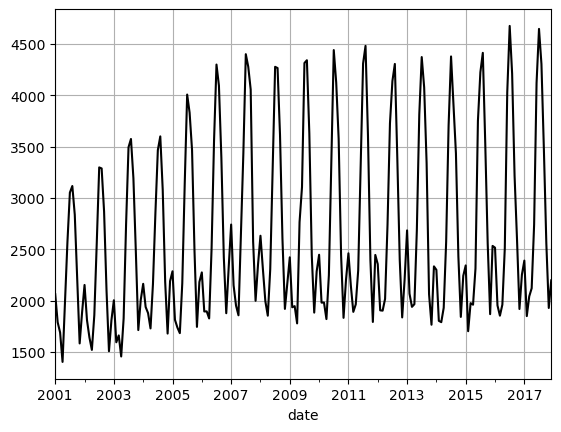

In [151]:
df_data.plot( x = 'date', y = 'Q', color = 'k', 
             legend = False, grid = True,  );

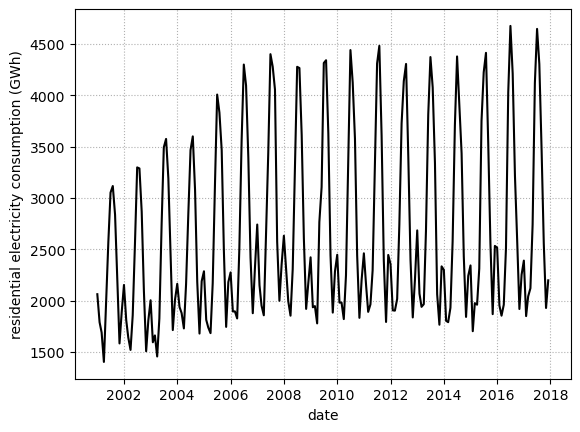

In [153]:
sns.lineplot(data = df_data, x = 'date', y = 'Q', legend = False, color = 'k')
plt.grid(linestyle = ':')
plt.ylabel('residential electricity consumption (GWh)');

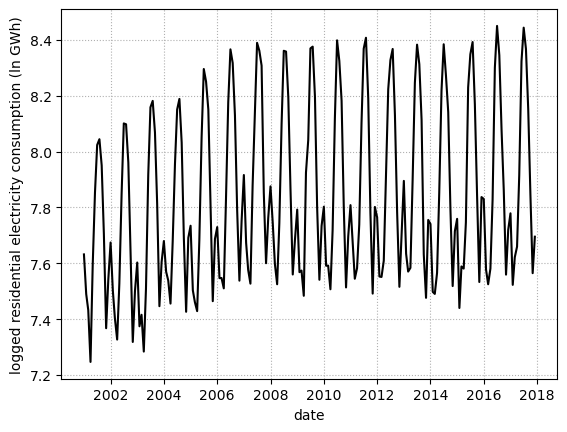

In [155]:
sns.lineplot(data = df_data, x = 'date', y = 'lnQ', legend = False, color = 'k')
plt.grid(linestyle = ':')
plt.ylabel('logged residential electricity consumption (ln GWh)');

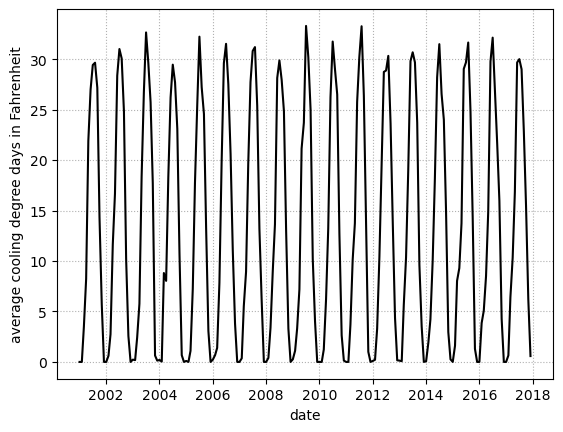

In [157]:
sns.lineplot(data = df_data, x = 'date', y = 'CLDD_avg', legend = False, color = 'k')
plt.grid(linestyle = ':')
plt.ylabel('average cooling degree days in Fahrenheit');

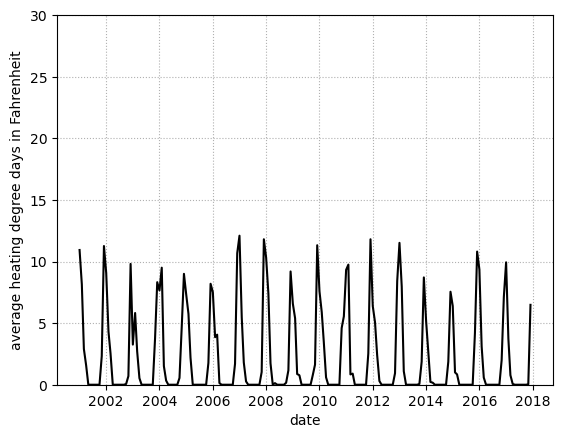

In [159]:
sns.lineplot(data = df_data, x = 'date', y = 'HTDD_avg', legend = False, color = 'k')
plt.grid(linestyle = ':')
plt.ylim(0,30)
plt.ylabel('average heating degree days in Fahrenheit');

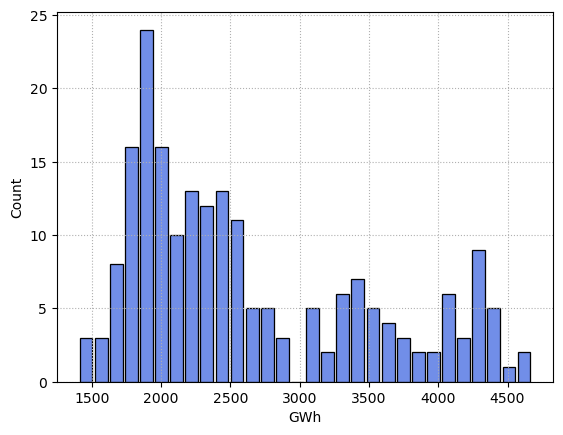

In [161]:
sns.histplot(data = df_data, x = 'Q', bins = 30, shrink = 0.85, color = 'royalblue')
plt.xlabel('GWh')
plt.grid(linestyle = ':');

In [163]:
df_data['CL_HT'] = df_data.CLDD_avg - df_data.HTDD_avg

In [165]:
df_data['temp'] = df_data.CL_HT.map(lambda x: 'cold' if x < 0 else 'warm')

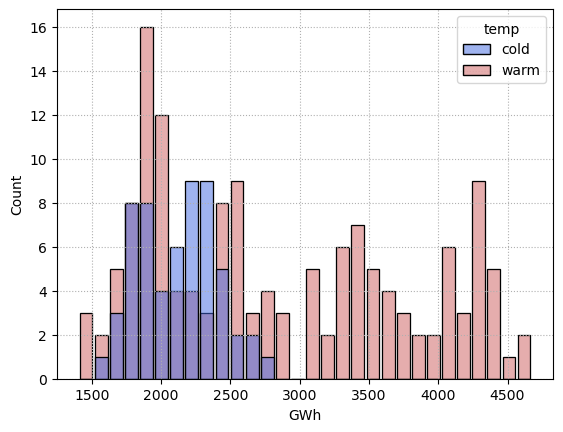

In [167]:
sns.histplot(
    data = df_data, x = 'Q', 
    hue = 'temp', palette = ['royalblue', 'indianred'],
    bins = 30, shrink = 0.85)
plt.xlabel('GWh')
plt.grid(linestyle = ':');

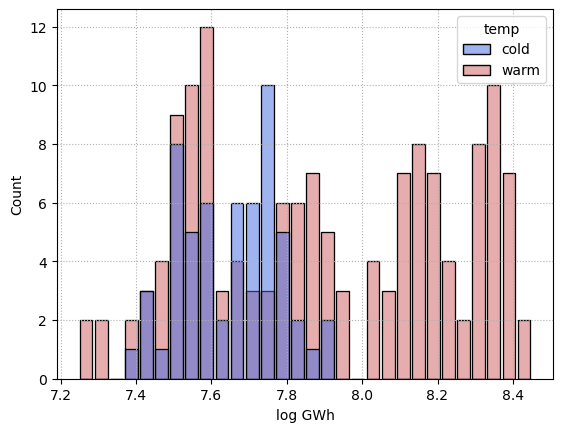

In [169]:
sns.histplot(
    data = df_data, x = 'lnQ', 
    hue = 'temp', palette = ['royalblue', 'indianred'],
    bins = 30, shrink = 0.85)
plt.xlabel('log GWh')
plt.grid(linestyle = ':');

In [171]:
for x in ["lnQ", "CLDD_avg", "HTDD_avg", "DX90_avg"]:
    df_data["D" + x] = df_data[x] - df_data[x].shift()

In [173]:
df_data.head()

,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,...,DX90_avg,Q,date,lnQ,CL_HT,temp,DlnQ,DCLDD_avg,DHTDD_avg,DDX90_avg
0,0,0,11,0,339,2001,1,2001m1,31,0.000000,...,0.000000,2063,2001-01-01,7.631917,-10.935484,cold,NaN,NaN,NaN,NaN
1,0,0,11,0,228,2001,2,2001m2,28,0.000000,...,0.000000,1790,2001-02-01,7.489971,-8.142857,cold,-0.141946,0.000000,-2.792627,0.000000
2,108,0,23,2,90,2001,3,2001m3,31,3.483871,...,0.064516,1690,2001-03-01,7.432484,0.580645,warm,-0.057487,3.483871,-5.239631,0.064516
3,247,0,27,11,47,2001,4,2001m4,30,8.233333,...,0.366667,1404,2001-04-01,7.247081,6.666667,warm,-0.185403,4.749462,-1.336559,0.302151
4,679,0,31,27,0,2001,5,2001m5,31,21.903226,...,0.870968,1984,2001-05-01,7.592870,21.903226,warm,0.345790,13.669892,-1.566667,0.504301


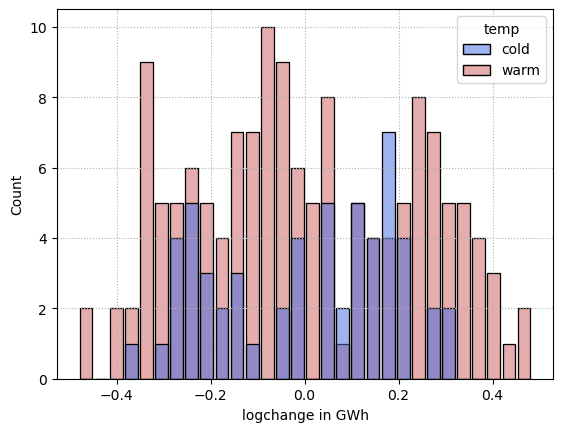

In [175]:
sns.histplot(
    data = df_data, x = 'DlnQ', 
    hue = 'temp', palette = ['royalblue', 'indianred'],
    bins = 30, shrink = 0.85)
plt.xlabel('logchange in GWh')
plt.grid(linestyle = ':');

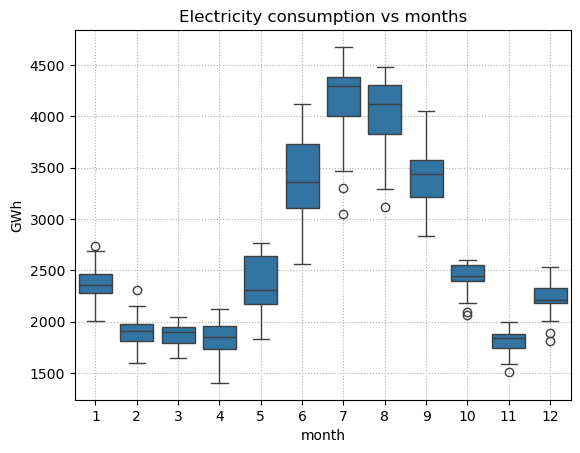

In [177]:
sns.boxplot(data = df_data, y = 'Q', x = 'month');
plt.xlabel('month')
plt.ylabel('GWh')
plt.title('Electricity consumption vs months')
plt.grid(linestyle = ':');

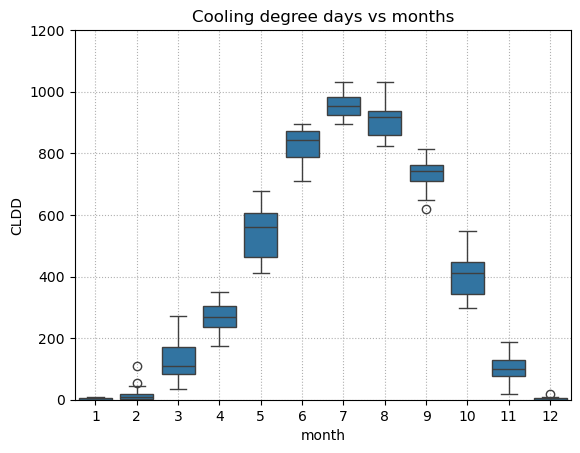

In [179]:
sns.boxplot(data = df_data, y = 'CLDD', x = 'month');
plt.xlabel('month')
plt.ylabel('CLDD')
plt.title('Cooling degree days vs months')
plt.ylim(0, 1200)
plt.grid(linestyle = ':');

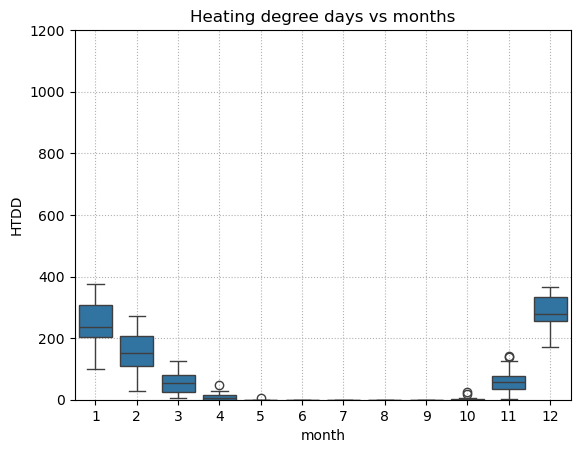

In [181]:
sns.boxplot(data = df_data, y = 'HTDD', x = 'month');
plt.xlabel('month')
plt.ylabel('HTDD')
plt.ylim(0, 1200)
plt.title('Heating degree days vs months')
plt.grid(linestyle = ':');

#### What is the right functional form?

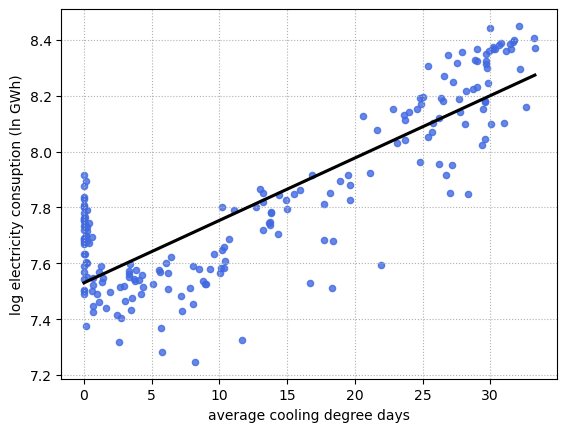

In [183]:
sns.regplot(data = df_data, x="CLDD_avg", y="lnQ", 
            ci = None, line_kws= {'color': 'k'}, scatter_kws= {'s': 20},
            color = 'royalblue')
plt.grid(linestyle = ':')
plt.xlabel('average cooling degree days')
plt.ylabel('log electricity consuption (ln GWh)');

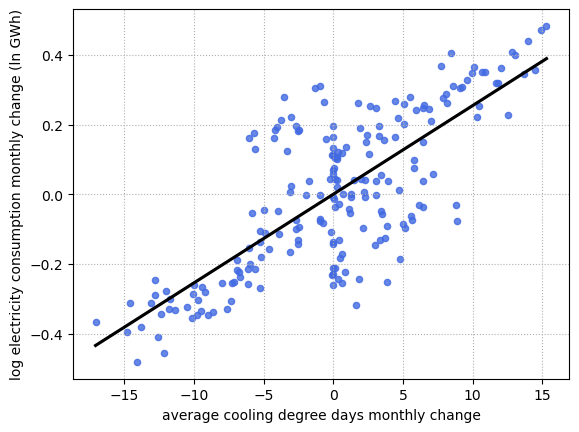

In [185]:
sns.regplot(data = df_data, x="DCLDD_avg", y="DlnQ", 
            ci = None, line_kws= {'color': 'k'}, scatter_kws= {'s': 20},
            color = 'royalblue')
plt.grid(linestyle = ':')
plt.xlabel('average cooling degree days monthly change')
plt.ylabel('log electricity consumption monthly change (ln GWh)');

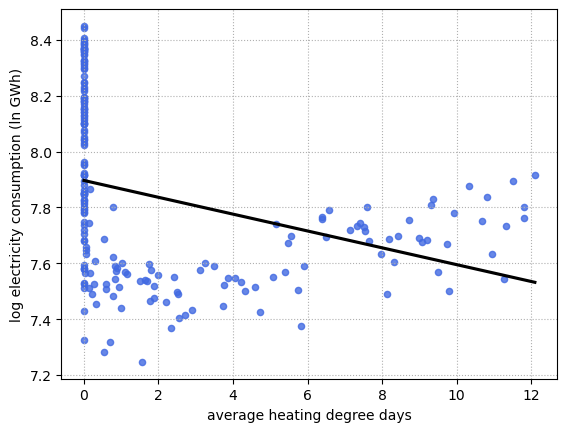

In [187]:
sns.regplot(data = df_data, x="HTDD_avg", y="lnQ", 
            ci = None, line_kws= {'color': 'k'}, scatter_kws= {'s': 20},
            color = 'royalblue')
plt.grid(linestyle = ':')
plt.xlabel('average heating degree days')
plt.ylabel('log electricity consumption (ln GWh)');

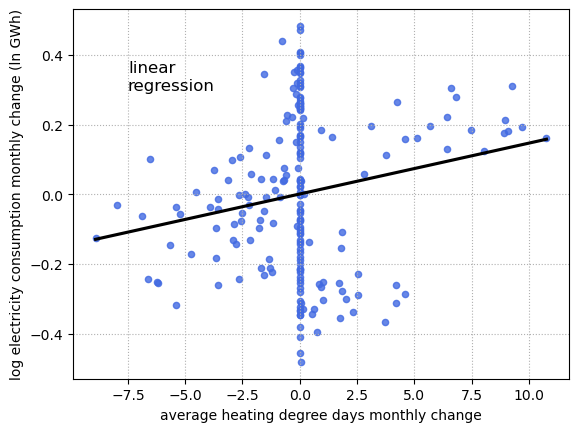

In [189]:
sns.regplot(data = df_data, x="DHTDD_avg", y="DlnQ", 
            ci = None, line_kws= {'color': 'k'}, scatter_kws= {'s': 20},
            color = 'royalblue')
plt.grid(linestyle = ':')
plt.xlabel('average heating degree days monthly change')
plt.ylabel('log electricity consumption monthly change (ln GWh)')
plt.text(x = -7.5, y = 0.3, s = 'linear\nregression', fontsize = 12);

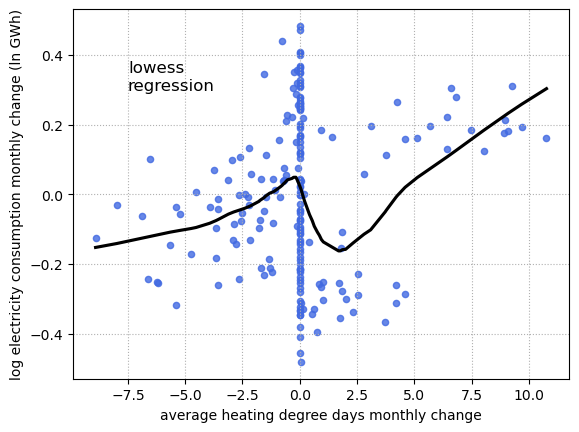

In [191]:
sns.regplot(data = df_data, x="DHTDD_avg", y="DlnQ", lowess = True,
            ci = None, line_kws= {'color': 'k'}, scatter_kws= {'s': 20},
            color = 'royalblue')
plt.grid(linestyle = ':')
plt.xlabel('average heating degree days monthly change')
plt.ylabel('log electricity consumption monthly change (ln GWh)')
plt.text(x = -7.5, y = 0.3, s = 'lowess\nregression', fontsize = 12);

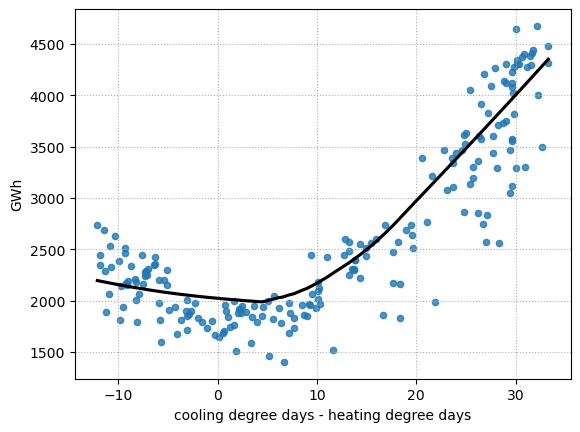

In [193]:
sns.regplot(data = df_data, x = 'CL_HT', y = 'Q', 
            lowess = True,
            # order = 2, 
            ci = None, 
            line_kws = {'color' : 'k'}, scatter_kws= {'s': 20})
plt.xlabel('cooling degree days - heating degree days')
plt.ylabel('GWh')
plt.grid(linestyle = ':');

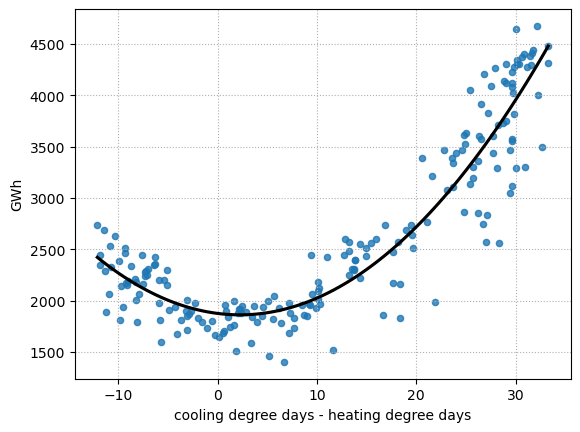

In [195]:
sns.regplot(data = df_data, x = 'CL_HT', y = 'Q', 
            # lowess = True,
            order = 2, 
            ci = None, 
            line_kws = {'color' : 'k'}, scatter_kws= {'s': 20})
plt.xlabel('cooling degree days - heating degree days')
plt.ylabel('GWh')
plt.grid(linestyle = ':');

#### Stationarity

**level**

In [197]:
print(PhillipsPerron(df_data.lnQ, lags=12, test_type="rho", trend="n").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                 -0.001
P-value                         0.714
Lags                               12
-------------------------------------

Trend: No Trend
Critical Values: -11.87 (1%), -6.87 (5%), -4.84 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


**diff**

In [200]:
print(PhillipsPerron(df_data[df_data.DlnQ.isna() == False].DlnQ, lags=12, test_type="rho", trend="n").summary())

     Phillips-Perron Test (Z-rho)    
Test Statistic                -43.294
P-value                         0.000
Lags                               12
-------------------------------------

Trend: No Trend
Critical Values: -11.87 (1%), -6.86 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Linear Regression

**log consumption change vs change in HTDD & CLDD**

In [204]:
reg1 = smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg", df_data).fit().get_robustcov_results(cov_type="HAC", maxlags=18)

In [206]:
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:                   DlnQ   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1114.
Date:                Tue, 29 Jul 2025   Prob (F-statistic):          3.65e-109
Time:                        18:45:36   Log-Likelihood:                 182.98
No. Observations:                 203   AIC:                            -360.0
Df Residuals:                     200   BIC:                            -350.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.002      0.477      0.6

**log consumption change vs change in HTDD & CLDD + months as factors**

In [209]:
reg2 = smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month)", df_data).fit().get_robustcov_results(cov_type="HAC", maxlags=18)

In [211]:
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     2310.
Date:                Tue, 29 Jul 2025   Prob (F-statistic):          1.64e-200
Time:                        18:45:41   Log-Likelihood:                 321.40
No. Observations:                 203   AIC:                            -614.8
Df Residuals:                     189   BIC:                            -568.4
Df Model:                          13                                         
Covariance Type:                  HAC                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0919      0.013      7.

**Question**: If months seem to be correlated with CLDD & HTDD, why do we have better results by adding the months as factors?

A good regression produces normally distributed residuals. Are our resudals follow a normal distribution (with $E({\epsilon_i})=0$)?

Visual inspection.

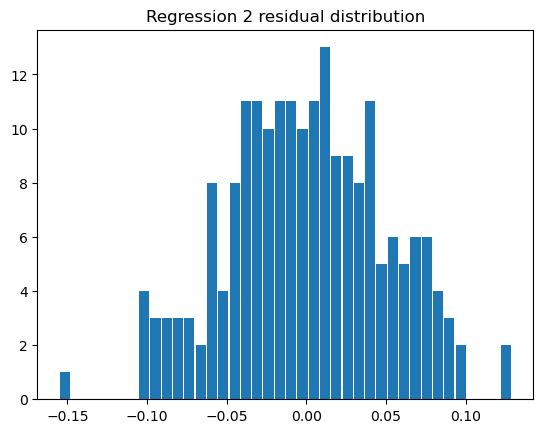

In [216]:
plt.hist(reg2.resid, bins = 40, rwidth = 0.9)
plt.title('Regression 2 residual distribution');

Formal statistical test.

In [219]:
from scipy.stats import kstest

stat, p = kstest(reg2.resid, 'norm')
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.454, p=0.000


In [221]:
kstest(reg2.resid, 'norm')

KstestResult(statistic=0.4542613381428842, pvalue=8.653154177576522e-39, statistic_location=-0.10248100026400744, statistic_sign=-1)

The $H_0$ of the `Kolmogorov-Smirnov Test` is that $x$ follows a normal distribution. Are our residuals normal?

**log consumption vs *level* of HTDD & CLDD + months as factors**

In [225]:
reg3 = smf.ols("DlnQ ~ CLDD_avg + HTDD_avg + C(month)", df_data).fit().get_robustcov_results(cov_type="HAC", maxlags=18)

In [227]:
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:                   DlnQ   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1207.
Date:                Tue, 29 Jul 2025   Prob (F-statistic):          4.12e-174
Time:                        18:46:01   Log-Likelihood:                 304.34
No. Observations:                 203   AIC:                            -580.7
Df Residuals:                     189   BIC:                            -534.3
Df Model:                          13                                         
Covariance Type:                  HAC                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0559      0.036     -1.

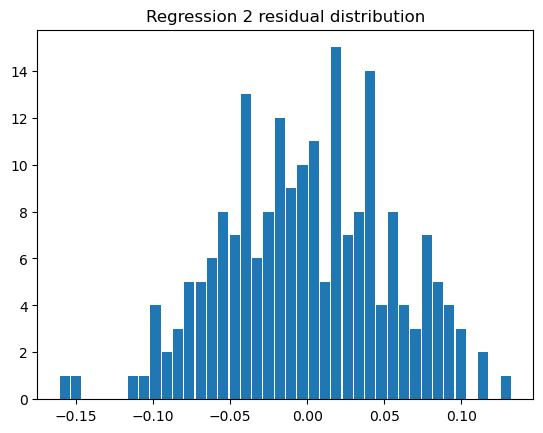

In [229]:
plt.hist(reg3.resid, bins = 40, rwidth = 0.9)
plt.title('Regression 2 residual distribution');

In [231]:
stat, p = kstest(reg3.resid, 'norm')
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.451, p=0.000


#### A digression into time series modelling: testing for autocorrelation

In [233]:
from statsmodels.graphics import tsaplots

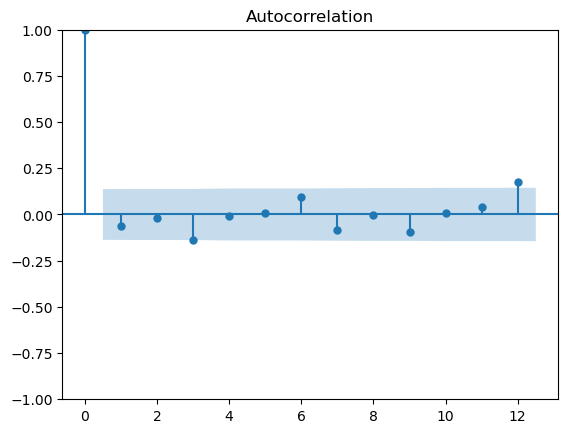

In [235]:
#plot autocorrelation function
fig = tsaplots.plot_acf(reg3.resid, lags = 12)
plt.show()

`Autocorrelation` means that elements of a tine series are correlated with/dependent on their previous values. *Dependence means that these elements are not random*! If residuals from  time series are autocorrelated, that is they are not random, then we are missing some important patterns from our model. Remember: if we can identify the correct pattern, than all we have left - the residuals - should be completely random. 

Autocorrelation can be sometimes handled by using the lagged value(s) of our dependent variable amongst the independent variables. Sometimes this hepls, sometimes does not. 

The `acf` function of the `statsmodels.api.tsa` package calculates autocorrelation between variables and their lagged values.

In [238]:
for i, v in enumerate(smapi.tsa.acf(reg3.resid)[0:13]):
    print('lag ' + str(i).rjust(2), str(f'{v:.3f}').rjust(7))

lag  0   1.000
lag  1  -0.065
lag  2  -0.018
lag  3  -0.141
lag  4  -0.010
lag  5   0.006
lag  6   0.093
lag  7  -0.082
lag  8  -0.003
lag  9  -0.097
lag 10   0.007
lag 11   0.040
lag 12   0.174


In [240]:
reg4 = smf.ols("DlnQ ~ CLDD_avg + HTDD_avg + C(month) + DlnQ.shift(1)", df_data).fit().get_robustcov_results(cov_type="HAC", maxlags=18)

In [242]:
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:                   DlnQ   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     1327.
Date:                Tue, 29 Jul 2025   Prob (F-statistic):          7.69e-179
Time:                        18:46:34   Log-Likelihood:                 311.40
No. Observations:                 202   AIC:                            -592.8
Df Residuals:                     187   BIC:                            -543.2
Df Model:                          14                                         
Covariance Type:                  HAC                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0094      0.032     -0.

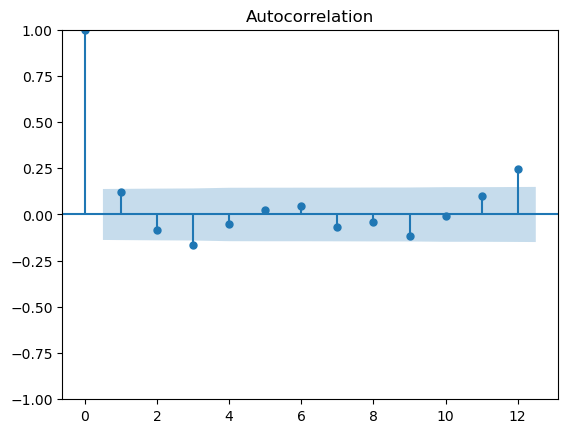

In [244]:
fig = tsaplots.plot_acf(reg4.resid, lags = 12)
plt.show()

#### Cumulative/long-run associations

In [247]:
df_data["DDCLDD_avg"] = df_data["DCLDD_avg"] - df_data["DCLDD_avg"].shift()
df_data["DDHTDD_avg"] = df_data["DHTDD_avg"] - df_data["DHTDD_avg"].shift()

In [249]:
reg5 = smf.ols(
    """DlnQ ~ 
        DCLDD_avg.shift(2) + DHTDD_avg.shift(2) + 
        DDCLDD_avg + DDHTDD_avg + 
        DDCLDD_avg.shift(1) + DDHTDD_avg.shift(1) + 
        C(month)""",
    df_data,
).fit()

In [251]:
stargazer = Stargazer([reg5])
stargazer.covariate_order(["DCLDD_avg.shift(2)", "DHTDD_avg.shift(2)"])
stargazer.rename_covariates(
    {
        "DCLDD_avg.shift(2)": "ΔCD cumulative coeff",
        "DHTDD_avg.shift(2)": "ΔHD cumulative coeff",
    }
)
stargazer